## Setup

In [1]:
# change into the src directory
import git
import os

repo = git.Repo('.', search_parent_directories=True)
os.chdir(repo.working_tree_dir)

In [2]:
from tapas_gmm.policy.models.tpgmm import ModelType, TPGMM, ReconstructionStrategy, FittingStage, InitStrategy, _xdx_to_tangent, TPGMMConfig, AutoTPGMMConfig, AutoTPGMM, FrameSelectionConfig, DemoSegmentationConfig, CascadeConfig
# import lovely_tensors as lt
# lt.monkey_patch()
from lovely_numpy import lo
import matplotlib.pyplot as plt

import pathlib
from pbdlib.utils.jupyter_utils import *
import numpy as np

from conf._machine import data_naming_config as machine_data_naming_config
from tapas_gmm.dataset.demos import Demos, PartialFrameViewDemos
import tapas_gmm.policy.models.tpgmm
from tapas_gmm.utils.misc import load_scene_data, DataNamingConfig
from tapas_gmm.utils.logging import setup_logger  # noqa: F401
from tapas_gmm.viz.gmm import plot_log_map_quaternions, plot_hmm_transition_matrix

%matplotlib inline

%load_ext autoreload
%autoreload 2

data_root = pathlib.Path(machine_data_naming_config.data_root).resolve()
data_root = data_root.parent / data_root.stem

np.set_printoptions(precision=2)

plt.style.use('default')

from IPython.display import HTML
from matplotlib import rc
rc('animation', html='jshtml')


2024-08-14 13:07:06.806 | INFO     |  Running on cuda:0


In [3]:
task = 'StackCups'
path = data_root / task / 'demos'

data_config = DataNamingConfig(
    feedback_type=None,
    task=None,
    data_root=None,
    path=path,
)

scene_data = load_scene_data(data_config)


2024-08-14 13:07:07.740 | INFO     |  Loading dataset(s): 
2024-08-14 13:07:07.740 | INFO     |    Initializing datasete using /home/hartzj/VinDihsl/MT-GMM/data/StackCups/demos/metadata.json
2024-08-14 13:07:07.746 | INFO     |    Extracted gt object labels [82, 87, 97]
2024-08-14 13:07:07.746 | INFO     |    Extracted tsdf object labels []
2024-08-14 13:07:07.746 | INFO     |    Done! Data contains 5 trajectories.


In [4]:
gt_pose_config = {}

gt_kp_config = {
    'encoder_name': 'demos_keypoints_gt_encoder-world',
    'cam': 'base',
}

kp_config = {
    'encoder_name': 'demos_vit_keypoints_encoder',
    'encoding_name': 'gtcopy',
}


In [5]:
observations = scene_data.get_demos(**gt_pose_config)

n_obs = len(observations)

demo_meta_data = {
    'path': path
}

data_kwargs = dict(
    meta_data=demo_meta_data,
    add_init_ee_pose_as_frame=True,
    add_world_frame=False,
    frames_from_keypoints=False,
    kp_indeces=None,
    enforce_z_up=False,
    modulo_object_z_rotation=False,
    make_quats_continuous=True
)

demos = Demos(observations, **data_kwargs)

2024-08-14 13:07:16.180 | INFO     |  Subsampling to length 244 using strategy mean-length.


In [6]:
tpgmm_config = TPGMMConfig(
    n_components=20,
    model_type=ModelType.HMM,
    use_riemann=True,
    add_time_component=True,
    add_action_component=False,
    position_only=True,

    add_gripper_action=True,

    reg_shrink=1e-2,
    reg_diag=2e-4,
    reg_diag_gripper=2e-2,

    reg_em_finish_shrink=1e-2,
    reg_em_finish_diag=2e-4,
    reg_em_finish_diag_gripper=2e-2,

    em_steps=1,

    trans_cov_mask_t_pos_corr = False,

    fix_first_component=True,
    fix_last_component=True,

    reg_init_diag=1e-4,  # 5

    heal_time_variance=False,
)

frame_selection_config = FrameSelectionConfig(
    init_strategy=InitStrategy.TIME_BASED,
    fitting_actions=(FittingStage.INIT,),
    rel_score_threshold=0.49,
    use_bic=False,

    drop_redundant_frames=False,
)

demos_segmentation_config = DemoSegmentationConfig(
    gripper_based=False,
    distance_based=False,
    velocity_based=True,

    repeat_final_step=0,
    repeat_first_step=0,

    components_prop_to_len=True,

    min_n_components=4,
)

cascade_config = CascadeConfig(
    kl_keep_time_dim=True,
    kl_keep_rotation_dim=False,
)

auto_tpgmm_config = AutoTPGMMConfig(
    tpgmm=tpgmm_config,
    frame_selection=frame_selection_config,
    demos_segmentation=demos_segmentation_config,
    cascade=cascade_config,
)


In [7]:
atpgmm = AutoTPGMM(auto_tpgmm_config)


2024-08-14 13:07:16.260 | INFO     |  Fitting AutoTPGMM
2024-08-14 13:07:16.260 | INFO     |  Performing fitting actions: [INIT]
2024-08-14 13:07:16.260 | INFO     |  Segmenting trajectories


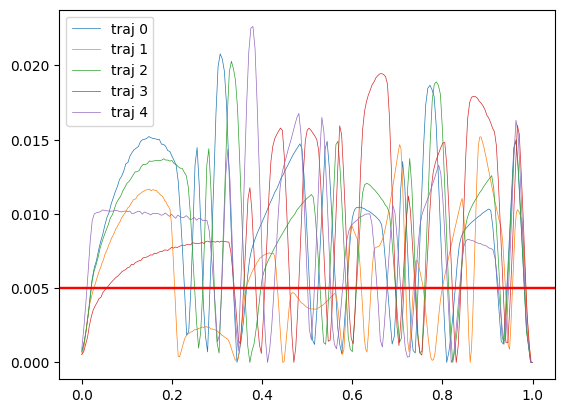

2024-08-14 13:07:16.378 | WARNING  |  Got different number of segmentation points for different trajectories.
Assuming it's because of settlement time.
Popping (tensor(175, dtype=torch.int32), tensor(200, dtype=torch.int32)) from traj 0 of len 216
2024-08-14 13:07:16.378 | WARNING  |  Got different number of segmentation points for different trajectories.
Assuming it's because of settlement time.
Popping (tensor(182, dtype=torch.int32), tensor(206, dtype=torch.int32)) from traj 2 of len 221
2024-08-14 13:07:16.378 | WARNING  |  Got different number of segmentation points for different trajectories.
Assuming it's because of settlement time.
Popping (tensor(196, dtype=torch.int32), tensor(222, dtype=torch.int32)) from traj 3 of len 237
2024-08-14 13:07:16.378 | WARNING  |  Got different number of segmentation points for different trajectories.
Assuming it's because of settlement time.
Popping (tensor(178, dtype=torch.int32), tensor(202, dtype=torch.int32)) from traj 4 of len 217
2024-08-

Time-based init:   0%|          | 0/5 [00:00<?, ?it/s]

2024-08-14 13:07:16.405 | INFO     |    Fitting candidate frame 2/4
2024-08-14 13:07:16.405 | INFO     |    Creating partial frame view of demos.


Time-based init:   0%|          | 0/5 [00:00<?, ?it/s]

2024-08-14 13:07:16.438 | INFO     |    Fitting candidate frame 3/4
2024-08-14 13:07:16.438 | INFO     |    Creating partial frame view of demos.


Time-based init:   0%|          | 0/5 [00:00<?, ?it/s]

2024-08-14 13:07:16.460 | INFO     |    Fitting candidate frame 4/4
2024-08-14 13:07:16.460 | INFO     |    Creating partial frame view of demos.


Time-based init:   0%|          | 0/5 [00:00<?, ?it/s]

2024-08-14 13:07:16.500 | INFO     |  ee_init    score (rel):     -1 (1.000)
2024-08-14 13:07:16.500 | INFO     |  obj000     score (rel):     -1 (1.000)
2024-08-14 13:07:16.500 | INFO     |  obj001     score (rel):     -0 (0.038)
2024-08-14 13:07:16.500 | INFO     |  obj002     score (rel):     -0 (0.085)
2024-08-14 13:07:16.501 | INFO     |  Creating partial frame view of demos.
2024-08-14 13:07:16.579 | INFO     |    Fitting candidate frame 1/4
2024-08-14 13:07:16.579 | INFO     |    Creating partial frame view of demos.
2024-08-14 13:07:16.583 | INFO     |    Changing number of components to 4


Time-based init:   0%|          | 0/4 [00:00<?, ?it/s]

2024-08-14 13:07:16.596 | INFO     |    Fitting candidate frame 2/4
2024-08-14 13:07:16.596 | INFO     |    Creating partial frame view of demos.


Time-based init:   0%|          | 0/4 [00:00<?, ?it/s]

2024-08-14 13:07:16.611 | INFO     |    Fitting candidate frame 3/4
2024-08-14 13:07:16.611 | INFO     |    Creating partial frame view of demos.


Time-based init:   0%|          | 0/4 [00:00<?, ?it/s]

2024-08-14 13:07:16.630 | INFO     |    Fitting candidate frame 4/4
2024-08-14 13:07:16.631 | INFO     |    Creating partial frame view of demos.


Time-based init:   0%|          | 0/4 [00:00<?, ?it/s]

2024-08-14 13:07:16.645 | INFO     |  ee_init    score (rel):     -0 (0.000)
2024-08-14 13:07:16.645 | INFO     |  obj001     score (rel):     -0 (0.000)
2024-08-14 13:07:16.646 | INFO     |  obj002     score (rel):     -0 (0.000)
2024-08-14 13:07:16.646 | INFO     |  Creating partial frame view of demos.
2024-08-14 13:07:16.647 | INFO     |    Fitting candidate frame 1/4
2024-08-14 13:07:16.647 | INFO     |    Creating partial frame view of demos.


Time-based init:   0%|          | 0/4 [00:00<?, ?it/s]

2024-08-14 13:07:16.663 | INFO     |    Fitting candidate frame 2/4
2024-08-14 13:07:16.663 | INFO     |    Creating partial frame view of demos.


Time-based init:   0%|          | 0/4 [00:00<?, ?it/s]

2024-08-14 13:07:16.734 | INFO     |    Fitting candidate frame 3/4
2024-08-14 13:07:16.735 | INFO     |    Creating partial frame view of demos.


Time-based init:   0%|          | 0/4 [00:00<?, ?it/s]

2024-08-14 13:07:16.762 | INFO     |    Fitting candidate frame 4/4
2024-08-14 13:07:16.762 | INFO     |    Creating partial frame view of demos.


Time-based init:   0%|          | 0/4 [00:00<?, ?it/s]

2024-08-14 13:07:16.778 | INFO     |  obj001     score (rel):     -0 (0.001)
2024-08-14 13:07:16.778 | INFO     |  obj002     score (rel):     -0 (0.003)
2024-08-14 13:07:16.778 | INFO     |  Creating partial frame view of demos.
2024-08-14 13:07:16.779 | INFO     |    Fitting candidate frame 1/4
2024-08-14 13:07:16.779 | INFO     |    Creating partial frame view of demos.


Time-based init:   0%|          | 0/4 [00:00<?, ?it/s]

2024-08-14 13:07:16.798 | INFO     |    Fitting candidate frame 2/4
2024-08-14 13:07:16.798 | INFO     |    Creating partial frame view of demos.


Time-based init:   0%|          | 0/4 [00:00<?, ?it/s]

2024-08-14 13:07:16.812 | INFO     |    Fitting candidate frame 3/4
2024-08-14 13:07:16.812 | INFO     |    Creating partial frame view of demos.


Time-based init:   0%|          | 0/4 [00:00<?, ?it/s]

2024-08-14 13:07:16.835 | INFO     |    Fitting candidate frame 4/4
2024-08-14 13:07:16.835 | INFO     |    Creating partial frame view of demos.


Time-based init:   0%|          | 0/4 [00:00<?, ?it/s]

2024-08-14 13:07:16.850 | INFO     |  ee_init    score (rel):     -0 (0.140)
2024-08-14 13:07:16.850 | INFO     |  obj001     score (rel):     -1 (0.999)
2024-08-14 13:07:16.850 | INFO     |  obj002     score (rel):     -0 (0.133)
2024-08-14 13:07:16.850 | INFO     |  Creating partial frame view of demos.
2024-08-14 13:07:16.851 | INFO     |    Fitting candidate frame 1/4
2024-08-14 13:07:16.851 | INFO     |    Creating partial frame view of demos.


Time-based init:   0%|          | 0/4 [00:00<?, ?it/s]

2024-08-14 13:07:16.868 | INFO     |    Fitting candidate frame 2/4
2024-08-14 13:07:16.868 | INFO     |    Creating partial frame view of demos.


Time-based init:   0%|          | 0/4 [00:00<?, ?it/s]

2024-08-14 13:07:16.885 | INFO     |    Fitting candidate frame 3/4
2024-08-14 13:07:16.886 | INFO     |    Creating partial frame view of demos.


Time-based init:   0%|          | 0/4 [00:00<?, ?it/s]

2024-08-14 13:07:16.904 | INFO     |    Fitting candidate frame 4/4
2024-08-14 13:07:16.904 | INFO     |    Creating partial frame view of demos.


Time-based init:   0%|          | 0/4 [00:00<?, ?it/s]

2024-08-14 13:07:16.919 | INFO     |  ee_init    score (rel):     -0 (0.001)
2024-08-14 13:07:16.919 | INFO     |  obj000     score (rel):     -0 (0.001)
2024-08-14 13:07:16.919 | INFO     |  obj001     score (rel):     -1 (1.000)
2024-08-14 13:07:16.919 | INFO     |  obj002     score (rel):     -0 (0.002)
2024-08-14 13:07:16.920 | INFO     |  Creating partial frame view of demos.
2024-08-14 13:07:16.920 | INFO     |    Fitting candidate frame 1/4
2024-08-14 13:07:16.921 | INFO     |    Creating partial frame view of demos.


Time-based init:   0%|          | 0/4 [00:00<?, ?it/s]

2024-08-14 13:07:16.935 | INFO     |    Fitting candidate frame 2/4
2024-08-14 13:07:16.935 | INFO     |    Creating partial frame view of demos.


Time-based init:   0%|          | 0/4 [00:00<?, ?it/s]

2024-08-14 13:07:16.982 | INFO     |    Fitting candidate frame 3/4
2024-08-14 13:07:16.983 | INFO     |    Creating partial frame view of demos.


Time-based init:   0%|          | 0/4 [00:00<?, ?it/s]

2024-08-14 13:07:17.001 | INFO     |    Fitting candidate frame 4/4
2024-08-14 13:07:17.001 | INFO     |    Creating partial frame view of demos.


Time-based init:   0%|          | 0/4 [00:00<?, ?it/s]

2024-08-14 13:07:17.028 | INFO     |  ee_init    score (rel):     -0 (0.061)
2024-08-14 13:07:17.028 | INFO     |  obj000     score (rel):     -0 (0.015)
2024-08-14 13:07:17.028 | INFO     |  obj002     score (rel):     -1 (1.000)
2024-08-14 13:07:17.029 | INFO     |  Creating partial frame view of demos.
2024-08-14 13:07:17.030 | INFO     |    Fitting candidate frame 1/4
2024-08-14 13:07:17.030 | INFO     |    Creating partial frame view of demos.


Time-based init:   0%|          | 0/4 [00:00<?, ?it/s]

2024-08-14 13:07:17.047 | INFO     |    Fitting candidate frame 2/4
2024-08-14 13:07:17.047 | INFO     |    Creating partial frame view of demos.


Time-based init:   0%|          | 0/4 [00:00<?, ?it/s]

2024-08-14 13:07:17.072 | INFO     |    Fitting candidate frame 3/4
2024-08-14 13:07:17.072 | INFO     |    Creating partial frame view of demos.


Time-based init:   0%|          | 0/4 [00:00<?, ?it/s]

2024-08-14 13:07:17.094 | INFO     |    Fitting candidate frame 4/4
2024-08-14 13:07:17.094 | INFO     |    Creating partial frame view of demos.


Time-based init:   0%|          | 0/4 [00:00<?, ?it/s]

2024-08-14 13:07:17.118 | INFO     |  Creating partial frame view of demos.
2024-08-14 13:07:17.120 | INFO     |    Fitting candidate frame 1/4
2024-08-14 13:07:17.120 | INFO     |    Creating partial frame view of demos.


Time-based init:   0%|          | 0/4 [00:00<?, ?it/s]

2024-08-14 13:07:17.136 | INFO     |    Fitting candidate frame 2/4
2024-08-14 13:07:17.136 | INFO     |    Creating partial frame view of demos.


Time-based init:   0%|          | 0/4 [00:00<?, ?it/s]

2024-08-14 13:07:17.171 | INFO     |    Fitting candidate frame 3/4
2024-08-14 13:07:17.171 | INFO     |    Creating partial frame view of demos.


Time-based init:   0%|          | 0/4 [00:00<?, ?it/s]

2024-08-14 13:07:17.190 | INFO     |    Fitting candidate frame 4/4
2024-08-14 13:07:17.190 | INFO     |    Creating partial frame view of demos.


Time-based init:   0%|          | 0/4 [00:00<?, ?it/s]

2024-08-14 13:07:17.206 | INFO     |  ee_init    score (rel):     -0 (0.016)
2024-08-14 13:07:17.206 | INFO     |  obj000     score (rel):     -0 (0.020)
2024-08-14 13:07:17.206 | INFO     |  obj002     score (rel):     -1 (0.999)
2024-08-14 13:07:17.206 | INFO     |  Creating partial frame view of demos.
2024-08-14 13:07:17.207 | INFO     |  Segmented trajs into 8 segments
2024-08-14 13:07:17.210 | INFO     |  Frame score (abs):
            ee_init    obj000    obj001    obj002
Segment 0 -0.999678 -0.999604 -0.038201 -0.084779
Segment 1 -0.000105 -0.999683 -0.000075 -0.000231
Segment 2 -0.000454 -0.999627 -0.000846 -0.002924
Segment 3 -0.139872 -0.999609 -0.998358 -0.133113
Segment 4 -0.001258 -0.000643 -0.999547 -0.001787
Segment 5 -0.061402 -0.014828 -0.999557 -0.999147
Segment 6 -0.000712 -0.000742 -0.000703 -0.999400
Segment 7 -0.015819 -0.020111 -0.999886 -0.998433
2024-08-14 13:07:17.211 | INFO     |  Frame score (rel):
            ee_init    obj000    obj001    obj002
Segment 0

Fitting segments:   0%|          | 0/8 [00:00<?, ?it/s]

2024-08-14 13:07:17.221 | INFO     |  Manifold: TIME x R3 x R3 x R1


Time-based init:   0%|          | 0/5 [00:00<?, ?it/s]

Time-based init:   0%|          | 0/4 [00:00<?, ?it/s]

Time-based init:   0%|          | 0/4 [00:00<?, ?it/s]

Time-based init:   0%|          | 0/4 [00:00<?, ?it/s]

Time-based init:   0%|          | 0/4 [00:00<?, ?it/s]

Time-based init:   0%|          | 0/4 [00:00<?, ?it/s]

Time-based init:   0%|          | 0/4 [00:00<?, ?it/s]

Time-based init:   0%|          | 0/4 [00:00<?, ?it/s]

((array([[3.26e+09, 3.29e+09, 2.77e+09, ..., 0.00e+00, 0.00e+00, 0.00e+00],
         [3.30e+06, 6.22e+06, 1.09e+07, ..., 3.15e-26, 3.63e-27, 8.12e-28],
         [4.03e-03, 2.49e-02, 1.45e-01, ..., 3.11e-02, 6.85e-03, 1.44e-03],
         [1.49e-16, 6.01e-16, 2.14e-15, ..., 1.13e+06, 5.90e+05, 3.04e+05],
         [0.00e+00, 0.00e+00, 0.00e+00, ..., 4.17e+08, 6.43e+08, 6.30e+08]]),
  array([[8130493.56, 8811388.27, 8424523.09, 6475968.59, 4354965.89,
          2374199.07, 1089423.5 ,  448867.2 ,  146310.64,   40140.49,
             9248.68,    1806.58,     215.8 ,      30.09,       3.53,
                0.16,       0.01,       0.  ,       0.  ,       0.  ,
                0.  ,       0.  , 2984607.21, 1906036.36, 1083498.73,
           403257.01,  145998.46,   49981.93,       0.  ,       0.  ,
                0.  ,       0.  ,       0.  ,       0.  ,       0.  ,
                0.  ,       0.  ,       0.  ,       0.  ,       0.  ,
                0.  ,       0.  ,       0.  ,       0.  , 

In [8]:
atpgmm.fit_trajectories(demos, fix_frames=True,
                       init_strategy=InitStrategy.TIME_BASED,
                       fitting_actions=(FittingStage.INIT,)) # FittingStage.EM_HMM))


2024-08-14 13:07:17.579 | INFO     |  Did not specify time_based, deciding automatically.
2024-08-14 13:07:17.609 | WARNING  |  Skippig NaN Gaussians.


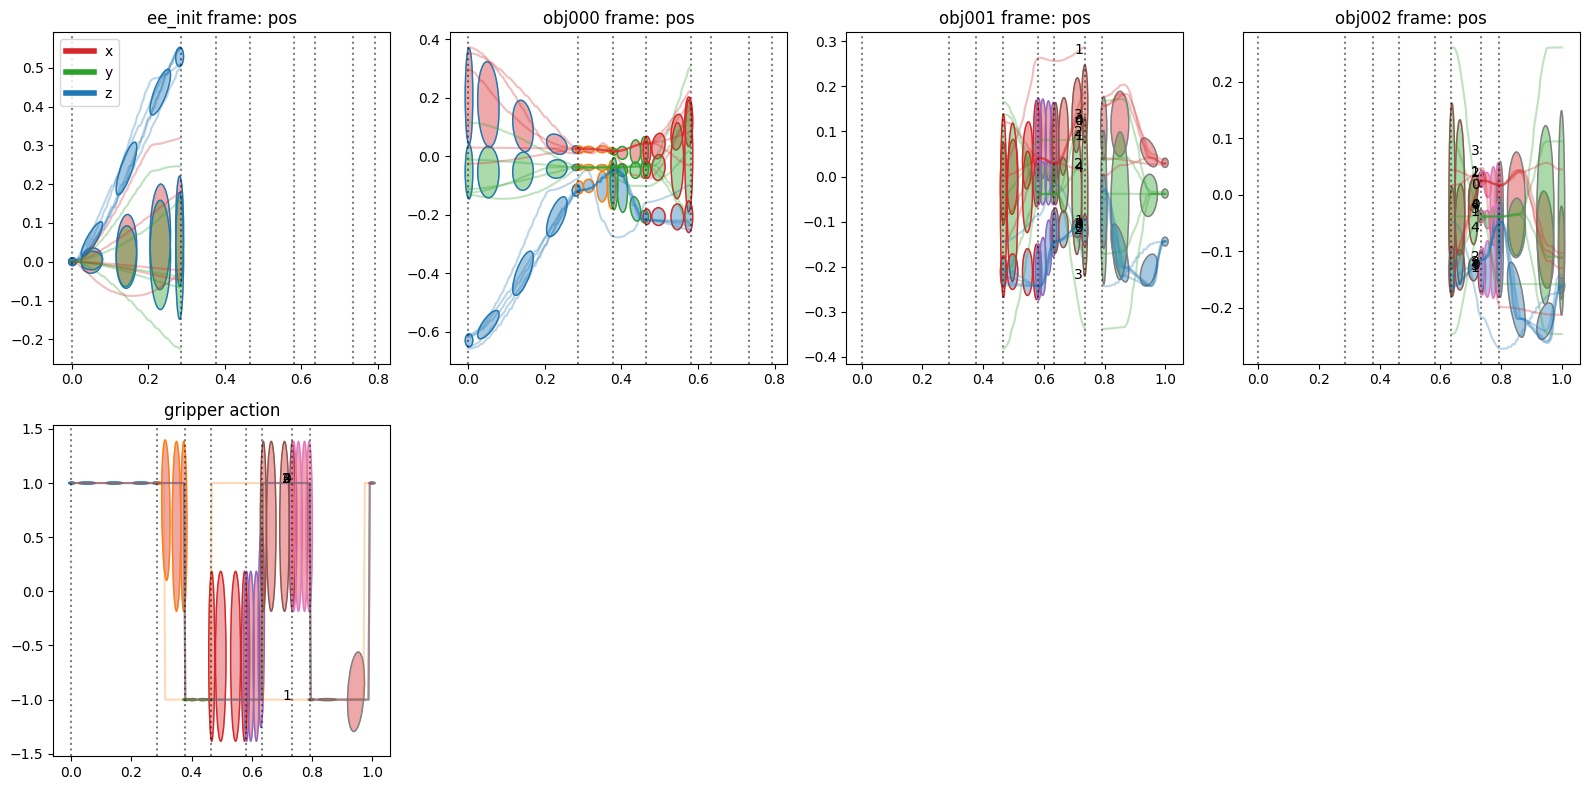

In [9]:
atpgmm.plot_model(
    scatter=True, rotations_raw=True, plot_traj=True, plot_gaussians=True,
    annotate_gaussians=False, annotate_trajs=True,
    mean_as_base=False, per_segment=False, gaussian_mean_only=False, plot_traj_means=False) #, size=(150, 10))


In [10]:
atpgmm.fit_trajectories(demos, fix_frames=True,
                       fitting_actions=(FittingStage.EM_HMM, ))


2024-08-14 13:07:18.987 | INFO     |  Fitting AutoTPGMM
2024-08-14 13:07:18.988 | INFO     |  Performing fitting actions: [EM_HMM]


Fitting segments:   0%|          | 0/8 [00:00<?, ?it/s]

2024-08-14 13:07:18.992 | INFO     |  HMM EM ...
2024-08-14 13:07:18.993 | INFO     |  HMM transition matrix not defined, initializing to uniform


HMM EM:   0%|          | 0/1 [00:00<?, ?it/s]

2024-08-14 13:07:18.999 | INFO     |  HMM init priors not defined, initializing to uniform
2024-08-14 13:07:19.018 | WARNING  |  HMM EM did not converge


HMM EM:   0%|          | 0/1 [00:00<?, ?it/s]

HMM EM:   0%|          | 0/1 [00:00<?, ?it/s]

HMM EM:   0%|          | 0/1 [00:00<?, ?it/s]

HMM EM:   0%|          | 0/1 [00:00<?, ?it/s]

HMM EM:   0%|          | 0/1 [00:00<?, ?it/s]

HMM EM:   0%|          | 0/1 [00:00<?, ?it/s]

HMM EM:   0%|          | 0/1 [00:00<?, ?it/s]

((array([[1., 1., 1., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 1., 1., 1.]]),
  array([[1.  , 1.  , 1.  , 0.99, 0.98, 0.96, 0.91, 0.8 , 0.58, 0.31, 0.11,
          0.03, 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  ,
          1.  , 1.  , 1.  , 0.99, 0.98, 0.94, 0.  , 0.  , 0.  , 0.  , 0.  ,
          0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  ,
          1.  , 1.  , 1.  , 0.99, 0.98, 0.96, 0.91, 0.79, 0.58, 0.3 , 0.1 ,
          0.02, 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  ,
          1.  , 1.  , 1.  , 0.99, 0.98, 0.96, 0.91, 0.8 , 0.57, 0.3 , 0.1 ,
          0.02, 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  ,
          1.  , 1.  , 1.  , 0.99, 0.98, 0.96, 0.91, 0.79, 0.58, 0.31, 0.1 ,
          0.03, 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  ],
         [0.  , 0.  , 0.  , 0.01, 0.0

2024-08-14 13:07:19.319 | INFO     |  Did not specify time_based, deciding automatically.


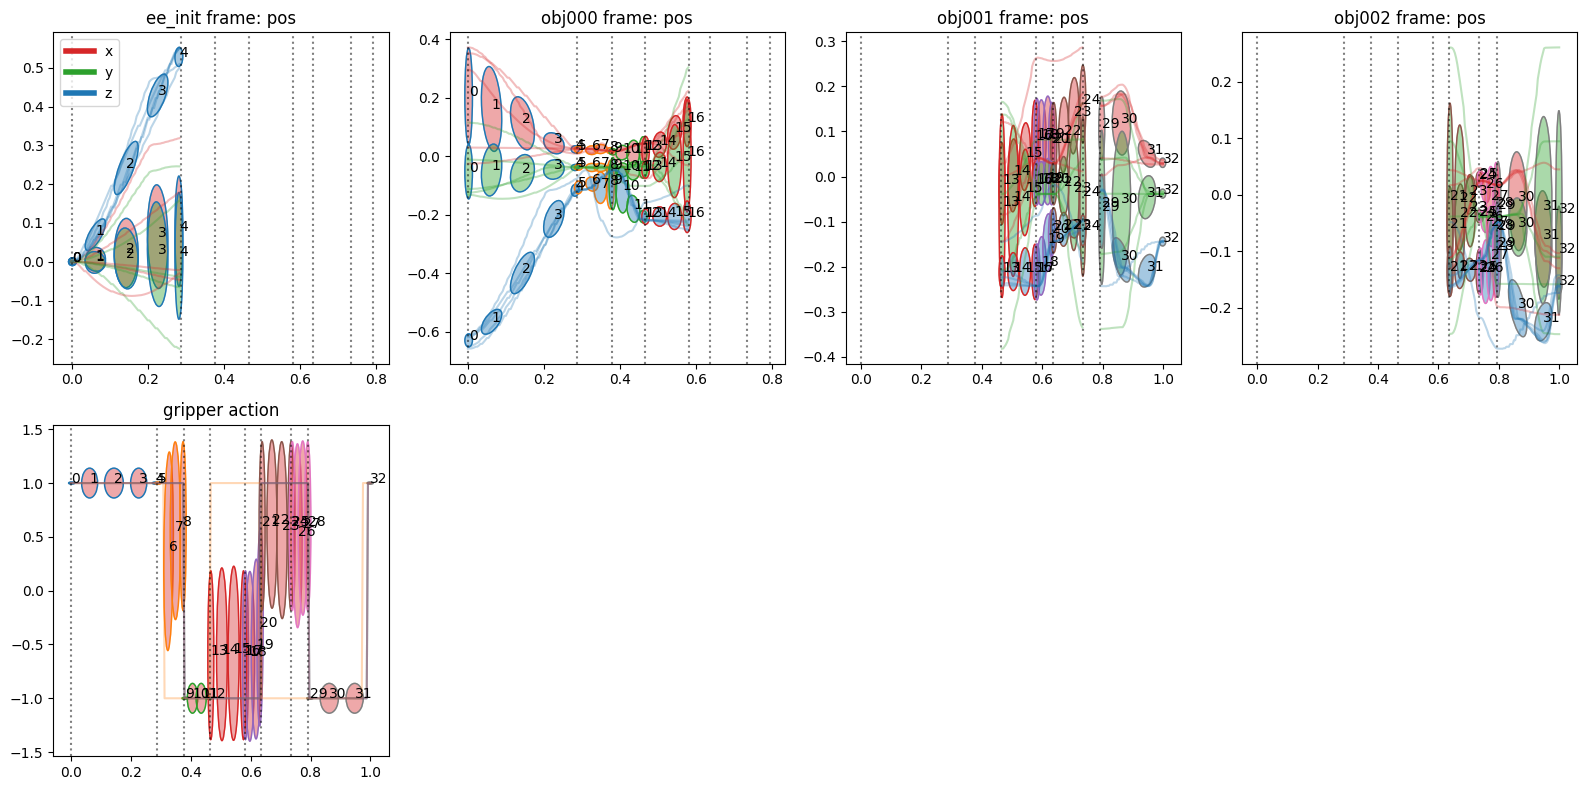

In [11]:

atpgmm.plot_model(
    scatter=True, rotations_raw=True, plot_traj=True, plot_gaussians=True,
    annotate_gaussians=True, annotate_trajs=False,
    mean_as_base=False, per_segment=False, gaussian_mean_only=False, plot_traj_means=False)

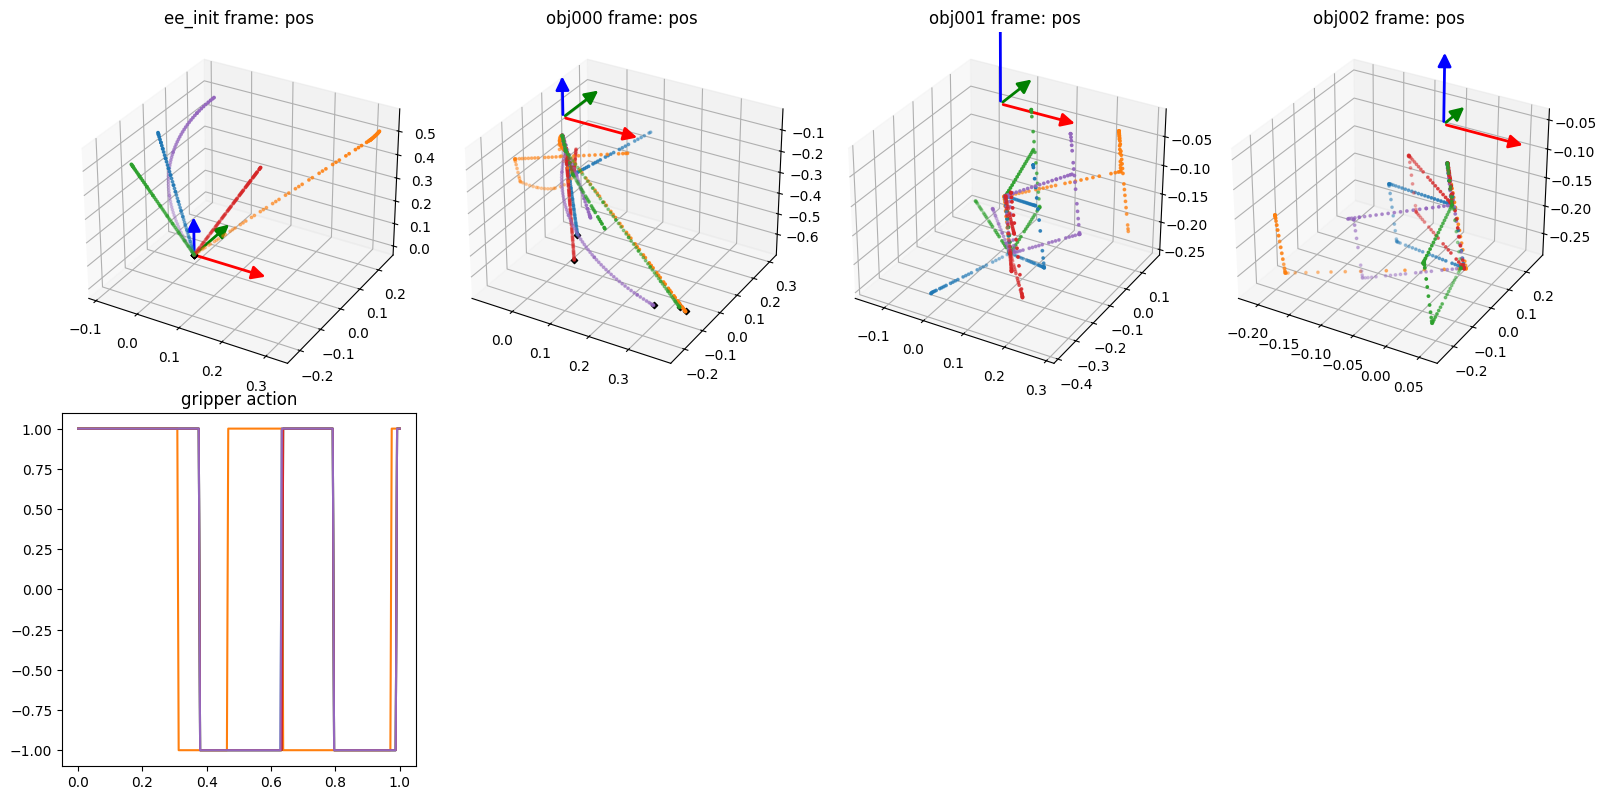

In [12]:
atpgmm.plot_model(
    scatter=True, rotations_raw=True, plot_traj=True, plot_gaussians=False,
    annotate_gaussians=True, annotate_trajs=False,
    mean_as_base=False, per_segment=False, gaussian_mean_only=False, plot_traj_means=False, time_based=False)

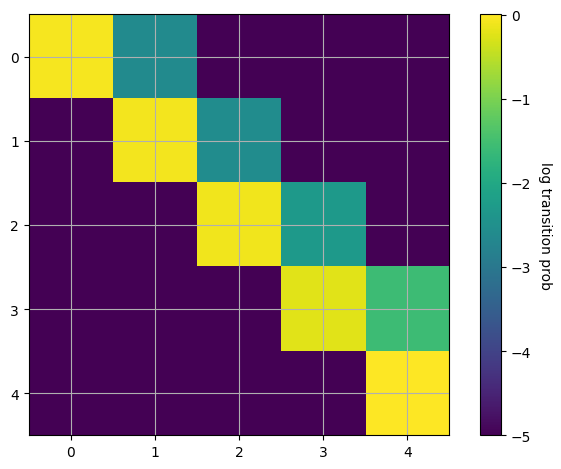

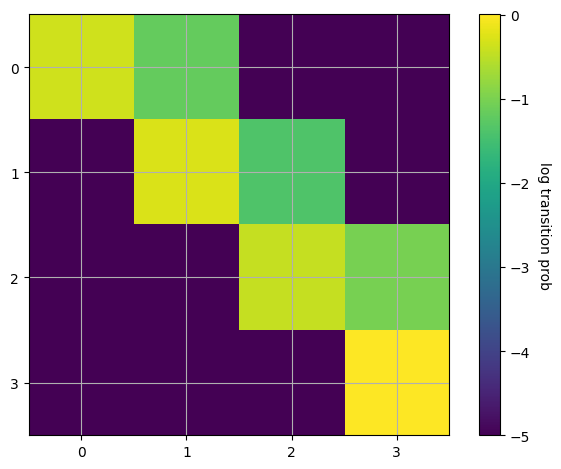

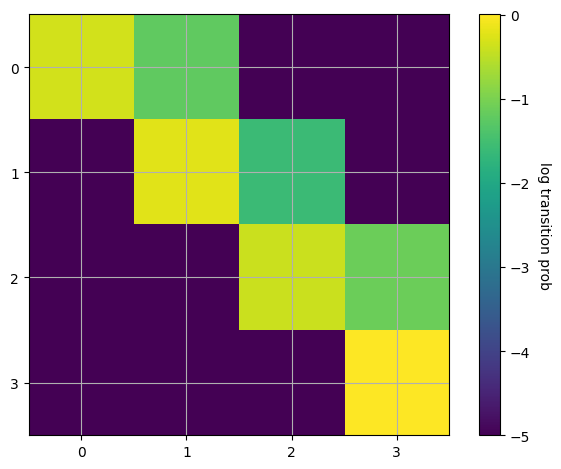

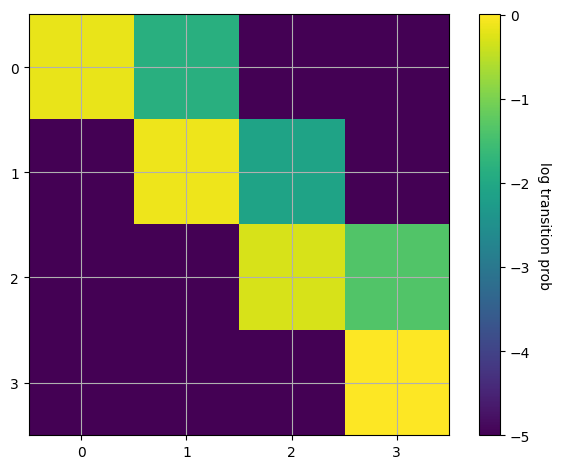

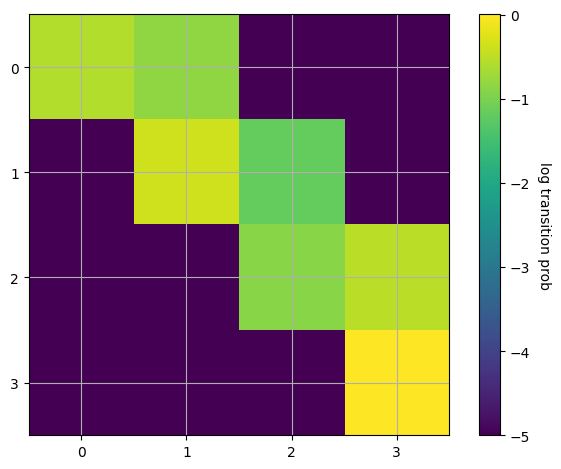

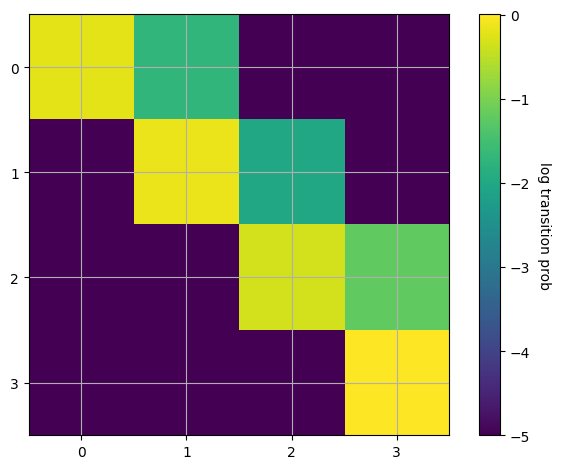

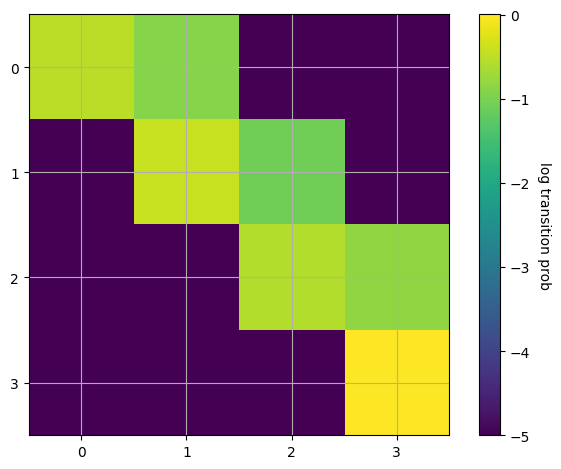

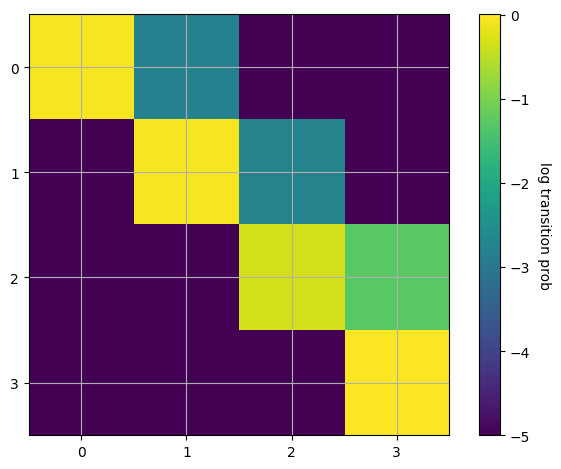

In [13]:
atpgmm.plot_hmm_transition_matrix()

In [14]:
atpgmm.to_disk(data_root / task / 'demos_gmm_policy-release.pt')

2024-08-14 13:07:22.409 | INFO     |  Saving model:


In [15]:
seg_local_marginals, seg_trans_marginals, seg_trans_marg_container, seg_joint_models, cascaded_hmms, (reconstructions, original_trajectories, extras) = atpgmm.reconstruct(
    strategy=tapas_gmm.policy.models.tpgmm.ReconstructionStrategy.GMR,
    use_ss=False)


2024-08-14 13:07:22.542 | INFO     |  Time-based reconstruction not specified. Auto selected True.
2024-08-14 13:07:22.687 | INFO     |  Caculated segment transition probabilities: (array([[0.89]]), array([[0.75]]), array([[0.86]]), array([[0.71]]), array([[0.81]]), array([[0.96]]), array([[0.86]]))
2024-08-14 13:07:22.688 | INFO     |  Creating partial frame view of demos.
2024-08-14 13:07:22.765 | INFO     |  Assuming zero frame velocity. Should be fixed.


Transforming marginals:   0%|          | 0/5 [00:00<?, ?it/s]

Joining marginals:   0%|          | 0/5 [00:00<?, ?it/s]

2024-08-14 13:07:22.785 | INFO     |  Creating partial frame view of demos.


Transforming marginals:   0%|          | 0/5 [00:00<?, ?it/s]

Joining marginals:   0%|          | 0/5 [00:00<?, ?it/s]

2024-08-14 13:07:22.801 | INFO     |  Creating partial frame view of demos.


Transforming marginals:   0%|          | 0/5 [00:00<?, ?it/s]

Joining marginals:   0%|          | 0/5 [00:00<?, ?it/s]

2024-08-14 13:07:22.815 | INFO     |  Creating partial frame view of demos.


Transforming marginals:   0%|          | 0/5 [00:00<?, ?it/s]

Joining marginals:   0%|          | 0/5 [00:00<?, ?it/s]

2024-08-14 13:07:22.843 | INFO     |  Creating partial frame view of demos.


Transforming marginals:   0%|          | 0/5 [00:00<?, ?it/s]

Joining marginals:   0%|          | 0/5 [00:00<?, ?it/s]

2024-08-14 13:07:22.861 | INFO     |  Creating partial frame view of demos.


Transforming marginals:   0%|          | 0/5 [00:00<?, ?it/s]

Joining marginals:   0%|          | 0/5 [00:00<?, ?it/s]

2024-08-14 13:07:22.885 | INFO     |  Creating partial frame view of demos.


Transforming marginals:   0%|          | 0/5 [00:00<?, ?it/s]

Joining marginals:   0%|          | 0/5 [00:00<?, ?it/s]

2024-08-14 13:07:22.900 | INFO     |  Creating partial frame view of demos.


Transforming marginals:   0%|          | 0/5 [00:00<?, ?it/s]

Joining marginals:   0%|          | 0/5 [00:00<?, ?it/s]

2024-08-14 13:07:22.919 | WARNING  |  Setting init priors of later segments to zero.


GMR:   0%|          | 0/5 [00:00<?, ?it/s]

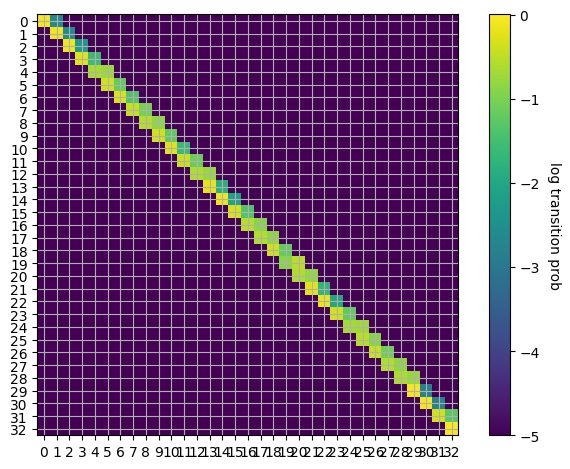

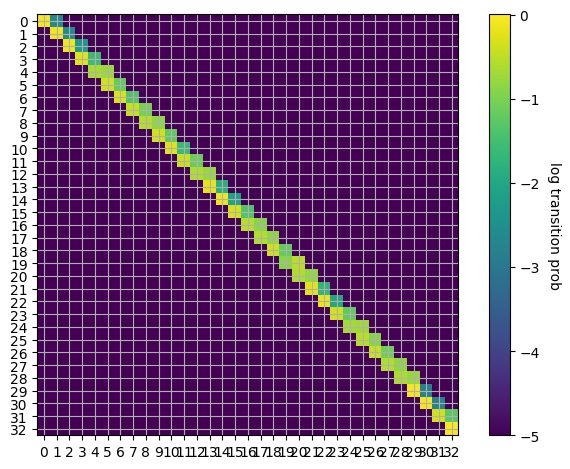

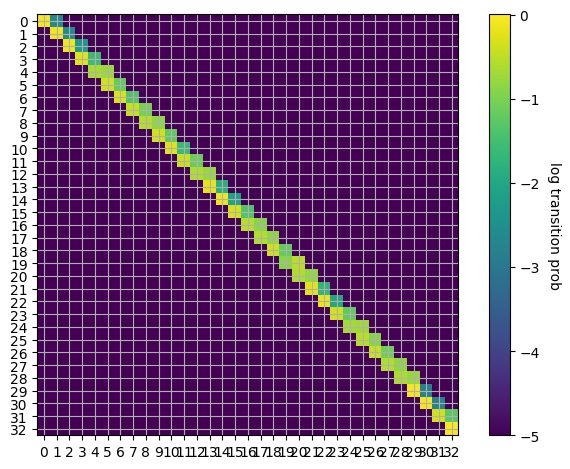

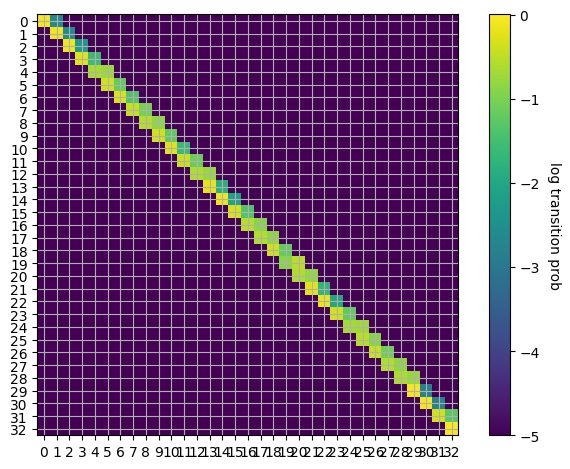

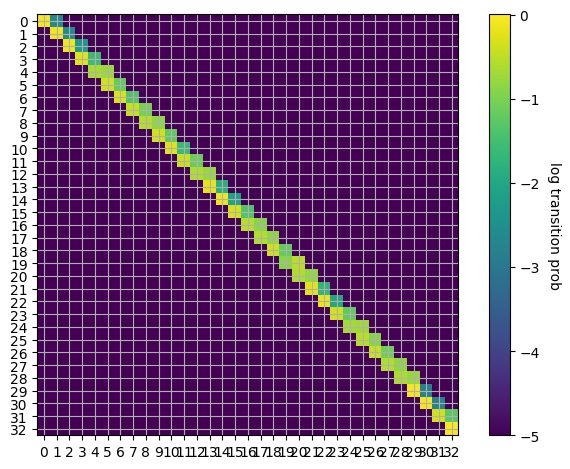

In [16]:
for cascaded_hmm in cascaded_hmms:
    plot_hmm_transition_matrix(cascaded_hmm)

2024-08-14 13:07:27.414 | INFO     |  Taking frame origins from demos.


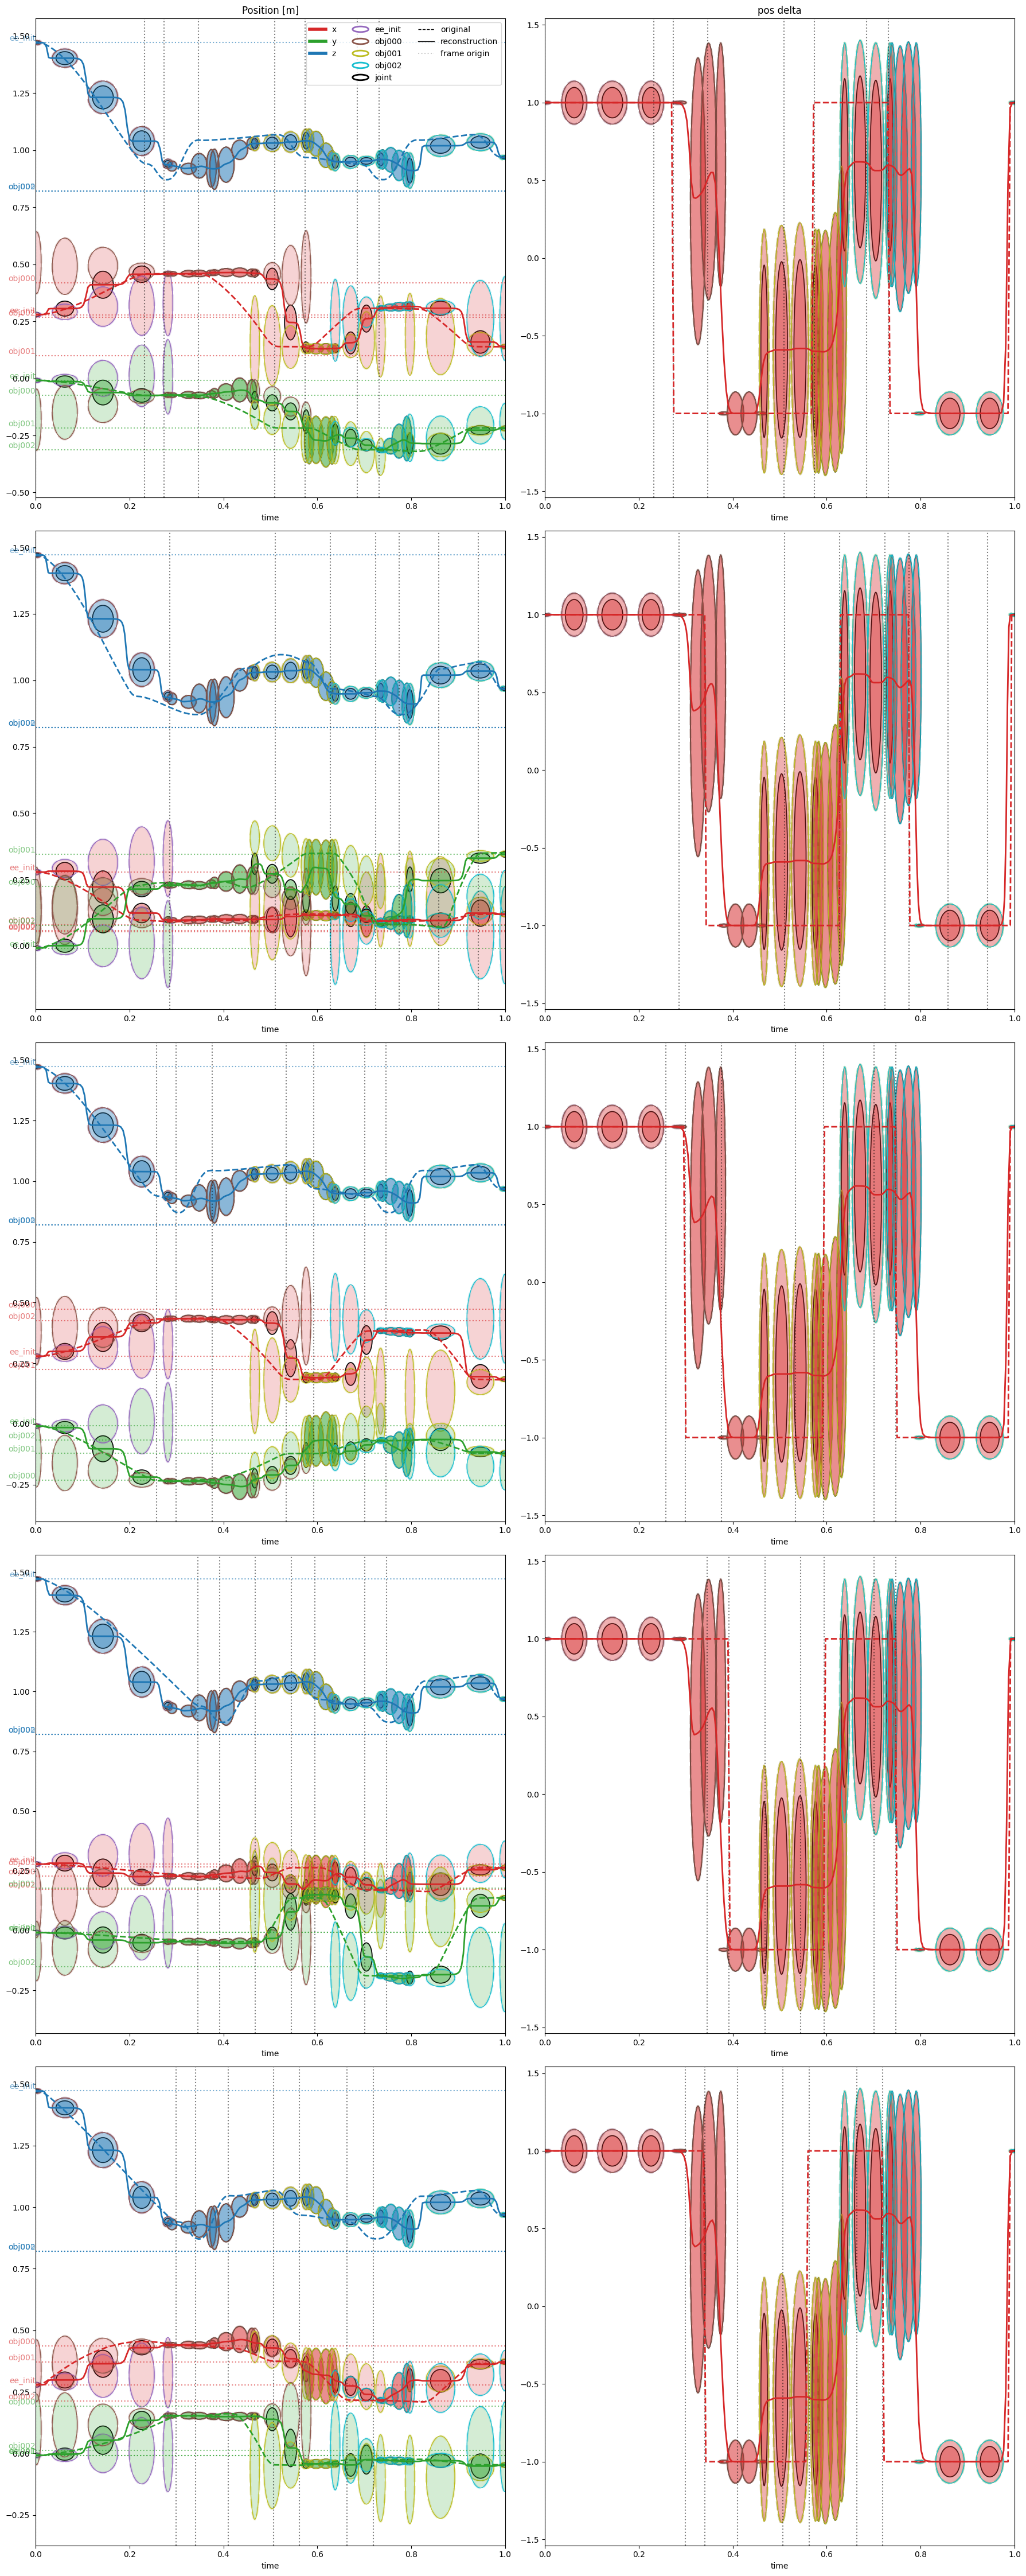

In [17]:

atpgmm.plot_reconstructions(
    seg_trans_marg_container, cascaded_hmms, reconstructions, original_trajectories,
    plot_trajectories=True, plot_reconstructions=True, plot_gaussians=True,
    time_based=True, equal_aspect=False, per_segment=False)


2024-08-14 13:07:36.554 | WARNING  |  Model uses moving frames. Can only plot one at a time. Plotting the one from the first time step.


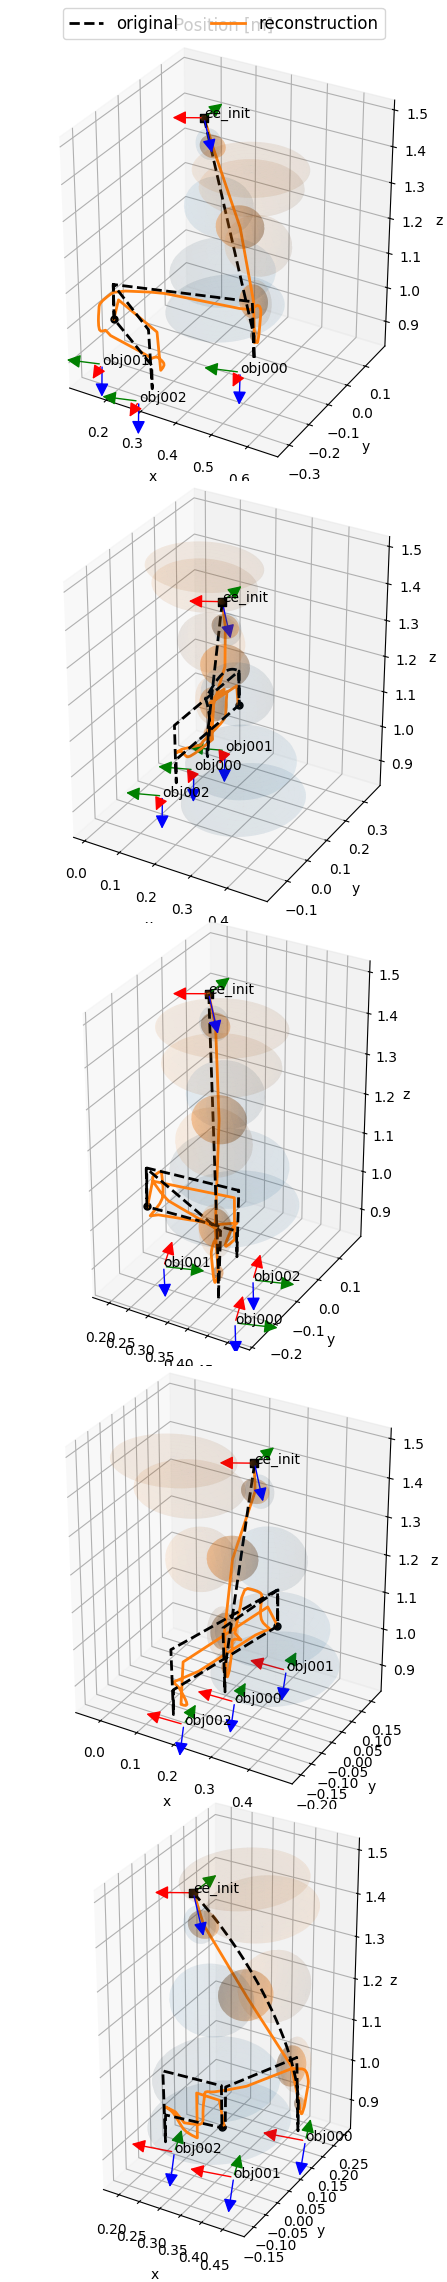

In [18]:
atpgmm.plot_reconstructions(
    seg_trans_marginals, seg_joint_models, reconstructions, original_trajectories,
    plot_trajectories=True, plot_reconstructions=True, plot_gaussians=True,
    time_based=False, equal_aspect=True, per_segment=False)
